# Utilization Prediction: Prediction of hourly utilization of the two sites

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Load and prepare data

In [2]:
# Load data
charging_data = pd.read_pickle("data/charging_modified.pkl")
weather_data = pd.read_csv("data/weather_modified.csv")

# drop not important columns in weather data
# TODO: what is this unnamed column here
weather_data.drop(columns = ["city", "cloud_cover_description", "pressure", "felt_temperature", "Unnamed: 0"], inplace = True)
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"], utc = True).dt.floor(freq = "H")

# drop not important columns in charging data
charging_data.drop(columns = ["kWhDelivered", "kWhPerMinute", "NoChargingTime", "user_modifiedAt", "doneChargingTime", "NoChargingTimeMinutes", "userRegistered", 
                              "spaceID", "stationID", "ChargingTime", "user_paymentRequired_values", "user_requestedDeparture", "userID", "ChargingTimeMinutes",
                              "user_kWhRequestFulfilment", "user_kWhRequested", "user_milesRequested", "user_minutesAvailable", "month", "weekday"], inplace = True)

# Delete rows with null values
charging_data = charging_data.dropna()

# delete duplicate row index
charging_data.reset_index(drop = True, inplace = True)

charging_data = charging_data.astype({
    "siteID": "int64"
})

weather_data.astype({
    "temperature": "float",
    "cloud_cover": "float",
    "windspeed": "float",
    "precipitation": "float"
})

charging_data

,id,connectionTime,disconnectTime,siteID,NoChargingTimeHours,ChargingTimeHours,user_WhPerMile
0,5bc915caf9af8b0dad3c0660,2018-04-30 15:07:49+00:00,2018-05-01 00:27:55+00:00,2,0.001111,9.333889,350.0
1,5bc917d0f9af8b0dc677b8bb,2018-05-07 14:38:18+00:00,2018-05-08 01:15:01+00:00,2,0.002222,10.609722,400.0
2,5bc9190ff9af8b0dc677b9c1,2018-05-11 15:17:01+00:00,2018-05-12 00:18:43+00:00,2,1.213056,7.815278,350.0
3,5bc919c3f9af8b0dc677ba32,2018-05-14 13:50:26+00:00,2018-05-14 23:09:45+00:00,2,2.434722,6.887222,400.0
4,5bc919c3f9af8b0dc677ba62,2018-05-15 00:06:39+00:00,2018-05-15 01:13:58+00:00,2,0.582500,0.539444,250.0
...,...,...,...,...,...,...,...
35385,6002419ff9af8b50514f4c45,2020-12-30 20:49:50+00:00,2020-12-30 21:25:49+00:00,1,0.003333,0.596389,279.0
35386,6002419cf9af8b50514f4c3f,2020-12-30 23:02:11+00:00,2020-12-31 02:53:06+00:00,2,2.737778,1.110833,290.0
35387,6002419ff9af8b50514f4c46,2020-12-31 03:56:09+00:00,2020-12-31 06:04:33+00:00,1,0.471944,1.668056,370.0
35388,6003931bf9af8b5261c8c794,2020-12-31 16:45:14+00:00,2020-12-31 17:30:59+00:00,2,0.001389,0.761111,283.0


## Create feature vector X and labels Y

In [3]:
# split time interval between connectionTime and disconnectTime in minutes for every hour
def split_time_interval(index, start_date, end_date):
    indices = pd.DatetimeIndex([start_date])
    indices = indices.append(pd.date_range(start_date.ceil(freq = "H"), end_date.floor(freq = "H"), freq = "H"))
    indices = indices.append(pd.DatetimeIndex([end_date]))

    time_list = list(map(lambda x : 60 if x == 0 else x, indices.minute))
    time_list[0] = 60 - time_list[0]
    
    return list((time_list, indices))


# creates table with session id, charging time in minutes per hour, timestamps and siteID
def create_minute_table(id, minute_array, siteID):
    return list(zip([id] * len(minute_array[0]), minute_array[0], minute_array[1], [siteID] * len(minute_array[0])))

# groups entries by timestamp
def group_by_timestamp(X):
    X = X.groupby("timestamp").agg({ "siteID": "mean", "charging_time_per_hour": "sum"})
    return X

In [4]:
# concat single minute lists to one big list with lists of tuples containing id, charging times in minutes per, timestamps and siteID
temp = []

for index in charging_data.index :
    charging_times = split_time_interval(charging_data.index[index], 
                                         charging_data.loc[index, "connectionTime"], 
                                         charging_data.loc[index, "disconnectTime"])
    temp.append(create_minute_table(charging_data.loc[index, "id"], charging_times, charging_data.loc[index, "siteID"]))
    
charging_data.drop("siteID", inplace = True, axis = 1)

# parse list of lists into four lists: ids, charging time in minutes per hour, timestamps and siteIDs
ids, charging_times, timestamps, siteIDs = map(list, zip(*[tuple for list in temp for tuple in list]))

# create data.frame with four columns: session id, charging time, starting timestamp in minutes for every hour and siteID
charging_time_per_hour = pd.DataFrame(
                            {"id": ids,
                             "charging_time_per_hour": charging_times,
                             "timestamp": timestamps,
                             "siteID": siteIDs})

charging_time_per_hour.loc[:, "timestamp"] = charging_time_per_hour.loc[:, "timestamp"].dt.floor(freq = "H")

### Labels Y:

In [5]:
# join charge time per hour with the rest of the charging data
temp = charging_time_per_hour.merge(charging_data, how = "left", on = "id").drop(["connectionTime", "disconnectTime", "id"], axis = 1)

# divide data set into two sets: one for each site
temp1 = temp.loc[temp["siteID"] == 1]
temp2 = temp.loc[temp["siteID"] == 2]

# group entries by timestamp
temp1 = group_by_timestamp(temp1)
temp2 = group_by_timestamp(temp2)

# combine the sets together into one
temp = pd.concat([temp1, temp2], axis = 0)

temp = temp.loc[temp["charging_time_per_hour"] <= 3000]

# roughly 50 EV charging stations per site * 60 minutes
maximum_utilization = 50 * 60

temp["hourlyUtilizationRate"] = temp.loc[:, "charging_time_per_hour"] / maximum_utilization
temp["timestamp"] = temp.index
temp.reset_index(drop = True, inplace = True)

In [6]:
Y = temp[["hourlyUtilizationRate", "timestamp", "siteID"]]
Y

,hourlyUtilizationRate,timestamp,siteID
0,0.021000,2018-10-08 13:00:00+00:00,1.0
1,0.174667,2018-10-08 14:00:00+00:00,1.0
2,0.300000,2018-10-08 15:00:00+00:00,1.0
3,0.300000,2018-10-08 16:00:00+00:00,1.0
4,0.300000,2018-10-08 17:00:00+00:00,1.0
...,...,...,...
22704,0.020000,2020-12-31 00:00:00+00:00,2.0
22705,0.020000,2020-12-31 01:00:00+00:00,2.0
22706,0.037667,2020-12-31 02:00:00+00:00,2.0
22707,0.005000,2020-12-31 16:00:00+00:00,2.0


### Feature Vector X:

In [7]:
X = temp.drop(["charging_time_per_hour", "hourlyUtilizationRate"],  axis = 1)

# add weather data to feature vector
X = X.merge(weather_data, how = "left", on = "timestamp").drop_duplicates(["timestamp", "siteID"]).fillna(0)

# add weekday and month as categorical variable
X["weekday"] = X["timestamp"].dt.day_name()
X["month"] = X["timestamp"].dt.month_name()
X["hour"] = X["timestamp"].dt.hour

# add utilization of past hours as rolling mean
X["rolling_utilization"] = Y["hourlyUtilizationRate"].rolling(window = 2).mean()
X = X.fillna(0)

# create dummies for categorical variables
X = X.astype({
    "siteID": "int64"
})
X = pd.get_dummies(X, columns = ["siteID", "weekday", "month", "hour"])

# sort values after siteID and timestamp in ascending order
X.sort_values(["siteID_2", "timestamp"])
X

,timestamp,temperature,cloud_cover,windspeed,precipitation,rolling_utilization,siteID_1,siteID_2,weekday_Friday,weekday_Monday,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2018-10-08 13:00:00+00:00,13.0,34.0,0.0,0.0,0.000000,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,2018-10-08 14:00:00+00:00,14.0,28.0,0.0,0.0,0.000000,True,False,False,True,...,True,False,False,False,False,False,False,False,False,False
4,2018-10-08 15:00:00+00:00,17.0,30.0,0.0,0.0,0.268667,True,False,False,True,...,False,True,False,False,False,False,False,False,False,False
5,2018-10-08 16:00:00+00:00,18.0,34.0,6.0,0.0,0.308917,True,False,False,True,...,False,False,True,False,False,False,False,False,False,False
6,2018-10-08 17:00:00+00:00,20.0,34.0,7.0,0.0,0.318917,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25442,2020-12-31 00:00:00+00:00,17.0,34.0,0.0,0.0,0.000000,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
25443,2020-12-31 01:00:00+00:00,15.0,33.0,6.0,0.0,0.000000,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
25444,2020-12-31 02:00:00+00:00,13.0,33.0,0.0,0.0,0.000000,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
25445,2020-12-31 16:00:00+00:00,9.0,30.0,6.0,0.0,0.000000,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False


## Cross-validation: split data in training and test set

In [8]:
# Split data into training set and testing set and normalize
scaler = StandardScaler()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state = 30)

X_train_scaled = scaler.fit_transform(X_train.drop("timestamp", axis = 1))
X_test_scaled = scaler.transform(X_test.drop("timestamp", axis = 1))

# create X sets for testing performance for each site
X_test_site1 = X_test[X_test["siteID_1"] == True].sort_values(["timestamp"])
X_test_site2 = X_test[X_test["siteID_2"] == True].sort_values(["timestamp"])

# create Y sets for testing performance for each site
Y_test_site1 = Y_test[Y_test["siteID"] == 1.0].sort_values("timestamp").drop("timestamp", axis = 1).loc[:, "hourlyUtilizationRate"]
Y_test_site2 = Y_test[Y_test["siteID"] == 2.0].sort_values("timestamp").drop("timestamp", axis = 1).loc[:, "hourlyUtilizationRate"]

Y_train = Y_train.loc[:, "hourlyUtilizationRate"]
Y_test = Y_test.loc[:, "hourlyUtilizationRate"]

In [9]:
Y_test

11087    0.020000
17106    0.070667
17805    0.042333
14001    0.528333
7407     0.087667
           ...   
5333     0.020000
11445    0.168667
4835     0.020000
513      0.359000
5959     0.954000
Name: hourlyUtilizationRate, Length: 6813, dtype: float64

## Prediction model 1: Neural Network

In [10]:
# Build the neural network
network = Sequential()

# Add layers
network.add(Dense(input_shape = (50,), units = 21, activation = "relu"))
network.add(Dropout(rate = 0.2))
network.add(Dense(units = 21, activation = "relu"))
network.add(Dropout(rate = 0.2))
network.add(Dense(units = 1, activation = "sigmoid"))

In [11]:
# Compiling the neural network
network.compile(optimizer = "adam", 
                   loss = "mean_squared_error", 
                   metrics = ["mean_squared_error"])
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ dense (Dense)                      │ (None, 21)                    │       1,071 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 21)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 21)                    │         462 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 21)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 1)                     │          22 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,555 (6.07 KB)

 Trainable params: 1,555 (6.07 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Fitting the Neural Network
network.fit(X_train_scaled, Y_train, batch_size=50, epochs=80)

Epoch 1/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1038 - mean_squared_error: 0.1038
Epoch 2/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0470 - mean_squared_error: 0.0470
Epoch 3/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0365 - mean_squared_error: 0.0365
Epoch 4/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 5/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0308 - mean_squared_error: 0.0308
Epoch 6/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0293 - mean_squared_error: 0.0293
Epoch 7/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 8/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0267 - mean_squared_error: 0.0267
Epoch 9/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0265 - mean_squared_error: 0.0265
Epoch 10/80
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0251 - mean_squared_error: 0.0251
Epoch 11/80
318/318 ━━━━━━━━━━━━━━━━━━━

### Performance evaluation

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# Evaluate performance
mse_nn  = mean_squared_error(Y_test, network.predict(X_test_scaled))
mae_nn  = mean_absolute_error(Y_test, network.predict(X_test_scaled))
msle_nn = mean_squared_log_error(Y_test, network.predict(X_test_scaled))
print("Mean squared error: " + str(mse_nn))
print("Mean absolute error: " + str(mae_nn))
print("Mean squared log error: " + str(msle_nn))

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean squared error: 0.019340275146837605
Mean absolute error: 0.08566429954828476
Mean squared log error: 0.010373920113404447


### Performance visualization

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


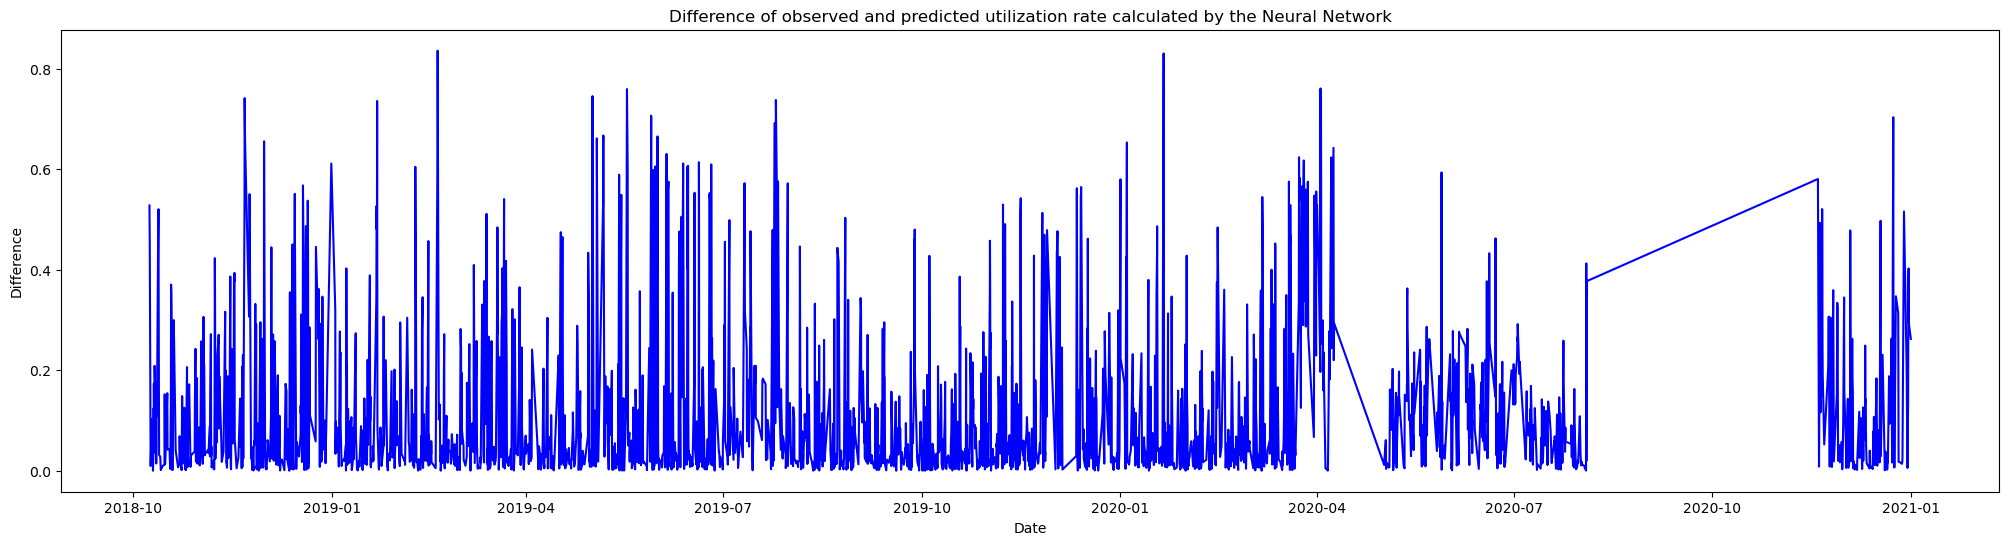

In [14]:
predictions_site1 = network.predict(scaler.transform(X_test_site1.drop("timestamp", axis = 1)))[:, 0]
timestamps = X_test_site1["timestamp"].sort_values()

# Visualization of difference between predicted and observed utilization rates for site 1
plt.figure(figsize = (25,6))
squared_error_site1_network = np.abs(predictions_site1 - Y_test_site1)

plt.plot(timestamps, squared_error_site1_network, c = "blue")

plt.xlabel("Date")
plt.ylabel("Difference")
plt.title("Difference of observed and predicted utilization rate calculated by the Neural Network")

plt.show()

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


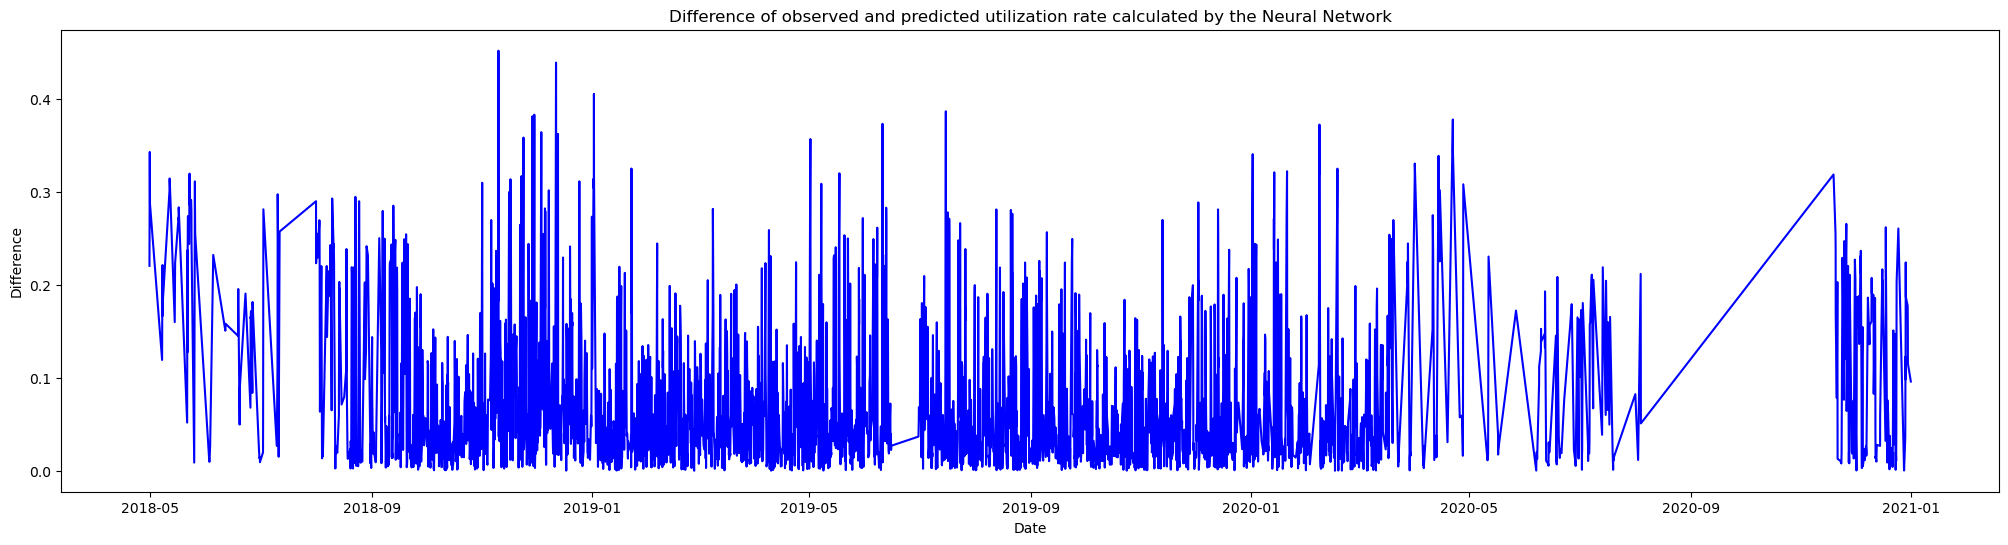

In [15]:
predictions_site2 = network.predict(scaler.transform(X_test_site2.drop("timestamp", axis = 1)))[:, 0]
timestamps = X_test_site2["timestamp"].sort_values()

# Visualization of difference between predicted and observed utilization rates for site 2
plt.figure(figsize = (25,6))
squared_error_site2_network = abs(predictions_site2 - Y_test_site2)

plt.plot(timestamps, squared_error_site2_network, c = "blue")

plt.xlabel("Date")
plt.ylabel("Difference")
plt.title("Difference of observed and predicted utilization rate calculated by the Neural Network")

plt.show()

## Prediction Model 2: Decision Tree

In [16]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

# fit decision tree for regression
reg_tree = DecisionTreeRegressor(max_depth = 10, criterion = "squared_error")
reg_tree.fit(X_train_scaled, Y_train)

DecisionTreeRegressor(max_depth=10)

In [17]:
# Plot tree
data = export_graphviz(reg_tree, feature_names = X.drop("timestamp", axis = 1).columns)
graph = graphviz.Source(data)

graph

### Performance Evaluation

In [18]:
# Evaluate performance
mse_dt    = mean_squared_error(Y_test, reg_tree.predict(X_test_scaled))
mae_dt    = mean_absolute_error(Y_test, reg_tree.predict(X_test_scaled))
r2_dt     = r2_score(Y_test, reg_tree.predict(X_test_scaled))
print("Mean squared error: " + str(mse_dt))
print("Mean absolute rror: " + str(mae_dt))
print("R2 score: " + str(r2_dt))

Mean squared error: 0.03425641825046271
Mean absolute rror: 0.11567207427989165
R2 score: 0.5276924590288417


### Performance visualization

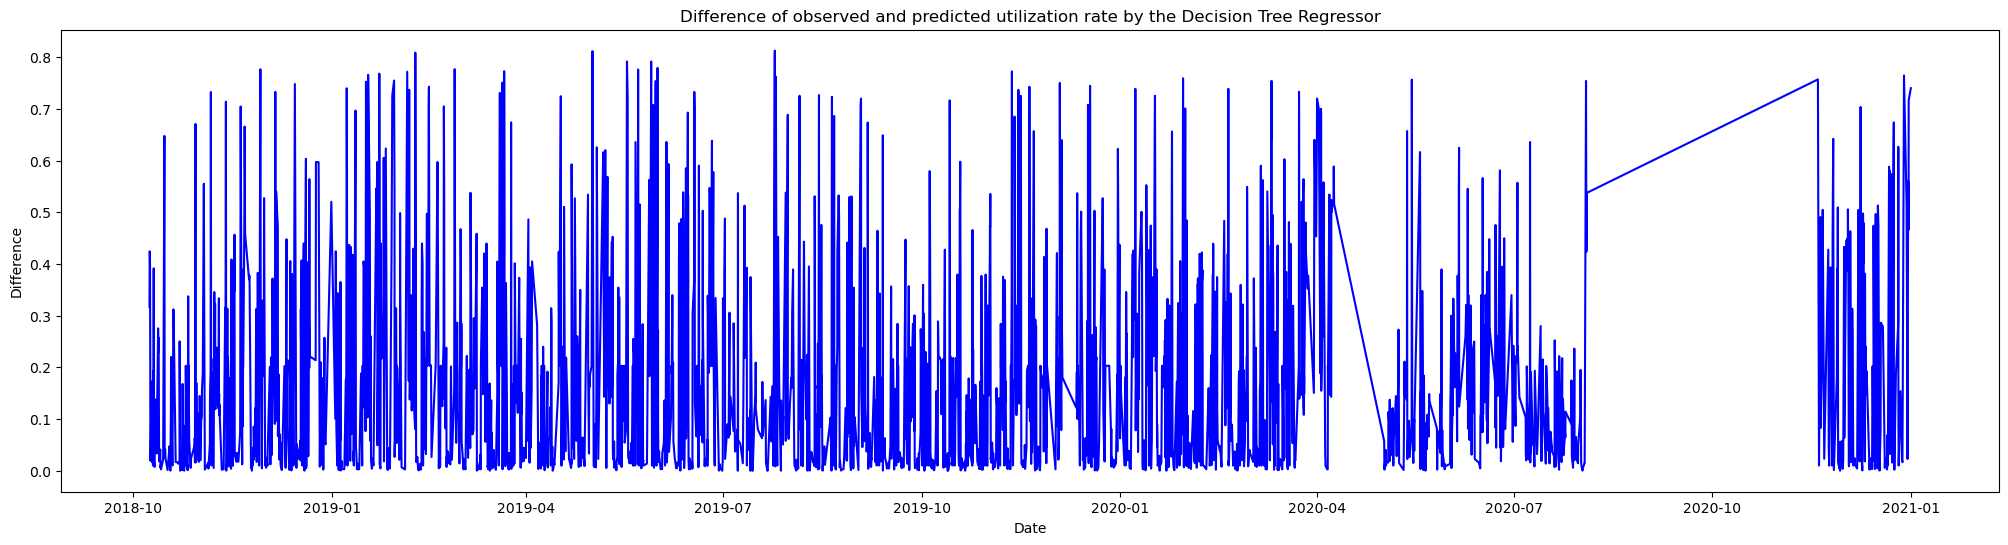

In [19]:
predictions_site1 = reg_tree.predict(scaler.transform(X_test_site1.drop("timestamp", axis = 1)))
timestamps = X_test_site1["timestamp"].sort_values()

# Visualization of difference between predicted and observed utilization rates for site 1
plt.figure(figsize = (25,6))
squared_error_site1_tree = np.abs(predictions_site1 - Y_test_site1)

plt.plot(timestamps, squared_error_site1_tree, c = "blue")

plt.xlabel("Date")
plt.ylabel("Difference")
plt.title("Difference of observed and predicted utilization rate by the Decision Tree Regressor")

plt.show()

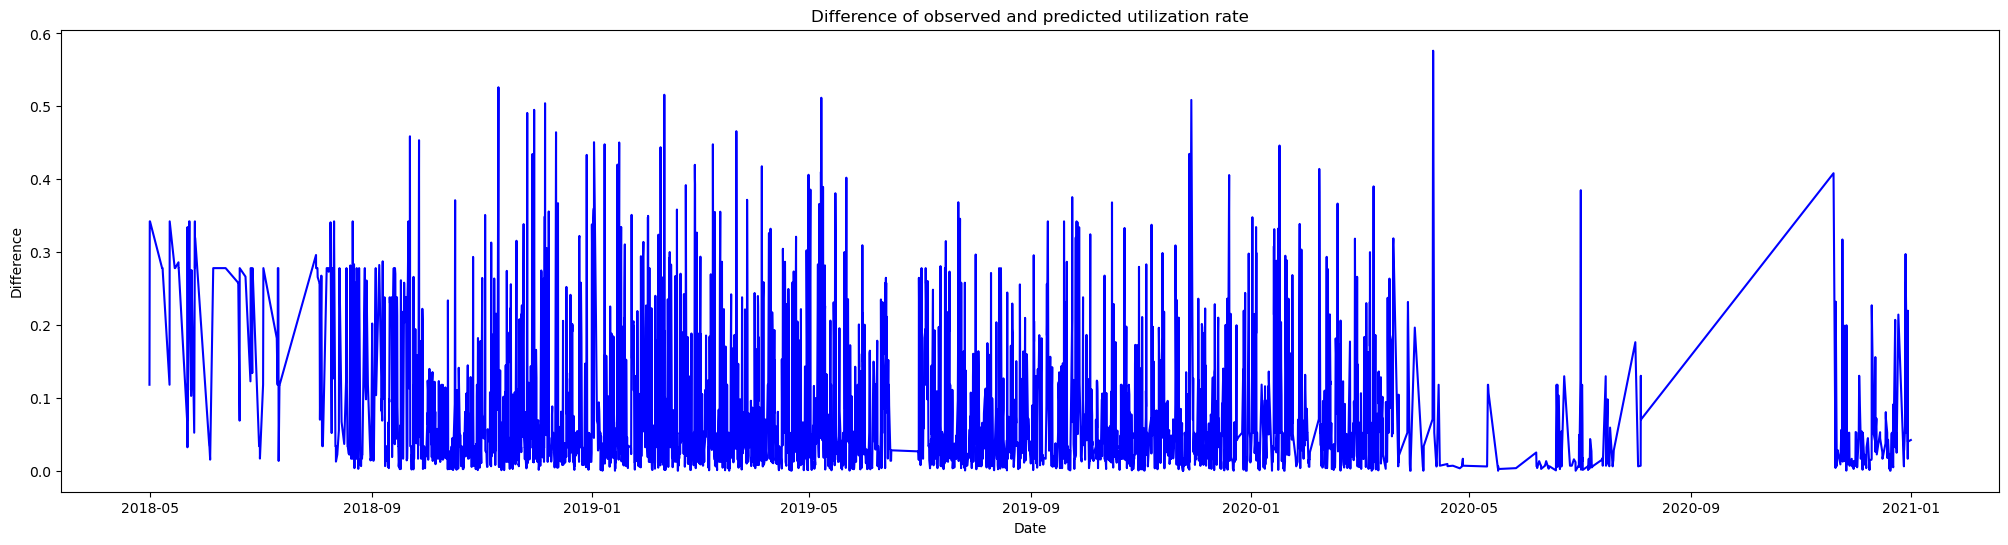

In [20]:
predictions_site2 = reg_tree.predict(scaler.transform(X_test_site2.drop("timestamp", axis = 1)))
timestamps = X_test_site2["timestamp"].sort_values()

# Visualization of difference between predicted and observed utilization rates for site 2
plt.figure(figsize = (25,6))
squared_error_site2_tree = np.abs(predictions_site2 - Y_test_site2)

plt.plot(timestamps, squared_error_site2_tree, c = "blue")

plt.xlabel("Date")
plt.ylabel("Difference")
plt.title("Difference of observed and predicted utilization rate")

plt.show()